This notebooks purpose is to visualise the tidal ellipses along the thalweg.

In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import re

import netCDF4 as nc
from scipy.optimize import curve_fit
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

#Load the parameters
The thalweg had 1539 pair of points. I chose 15 stations at increments of 100 points along the thalweg and calculated the tidal ellipse parameters for these locations

In [20]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lats = grid_B.variables['nav_lat'][:]
lons = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

In [210]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 23)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
loc = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1400, 1500]
count = np.arange(0,15)
params = np.zeros((15,39,5))
params_av = np.zeros((15,8))
cols=np.arange(0,5)

i = np.zeros((15))
j = np.zeros((15))

for k,l in zip(loc,count):
    i = thalweg[1,loc]
    j = thalweg[0,loc]
    runname1 = '{}_{}_thalweg_{}'.format(t_o, t_f, k)
    runname2 = '{}_{}_thalweg_{}_depav(20-200)'.format(t_o, t_f, k)
    df1 = pd.read_csv(runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv(runname2+'.csv', index_col=False)
    params[l,:,:] = df1.as_matrix()
    #params_av[l] = df2.dtypes()
    #params_av[l] = [df2['Major(M2)'][0], df2['Minor(M2)'][0], df2['Inc(M2)'][0], df2['Pha(M2)'][0]]

##Plot of locations

(898, 398)


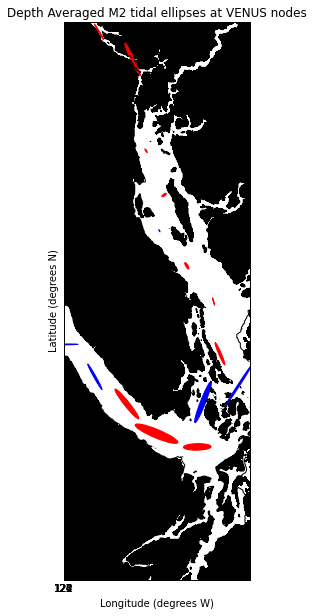

In [121]:
phi=0
fig = plt.figure(figsize=(10,10))
k = np.zeros((898,398)); m = np.zeros((898,398))
ax = fig.add_subplot(111)
viz_tools.set_aspect(ax) 
ex = 0

imin=0
imax = 320

jmin = 50
jmax = 895

for q in np.arange(jmin-ex,jmax+ex):
    for l in np.arange(imin-ex,imax+ex):
        k[q,l] = q*np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q,l] = -q*np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.) 
scale = 100
dep=10

#Making the ellipse for the Central node

count = np.arange(0,15)

for loc, r, l in zip(count, i ,j):
    if params[loc,dep,2] > 0:
        thec = 'b'
    else:
        thec = 'r'
    ellsc = Ellipse(xy=(m[l,r],k[l,r]), width=scale*params[loc,dep,1], 
                        height=scale*params[loc,dep,2], angle=params[loc, dep,3]-29,
                        color=thec)
    ax.add_artist(ellsc)
    ellsc.set_facecolor(thec)

# y-axis in k, but labelled in latitude
#ax.set_ylim(300,350)
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(44, 50, 0.5)-
                           lats[jmin,imin])/slope).tolist()
labels = ['44.5','45','45.5','46','47','48', '49','50']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)')
# x-axis in m, but labelled in longitude
#ax.set_xlim(100,120)
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-127,-120.5,1)-
                        lons[jmin,imin])/slope).tolist()
labels = ['127','126','125','124','123','122','121', '120']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)')
print bathy.data.shape

# land, and 5 m contour
contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
        bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],contour_interval,colors='black')
ax.contour(m[jmin-ex:jmax+ex,imin-ex:imax+ex],k[jmin-ex:jmax+ex,imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex,imin-ex:imax+ex],[5],colors='black')
ax.set_title('Depth Averaged M2 tidal ellipses at VENUS nodes')


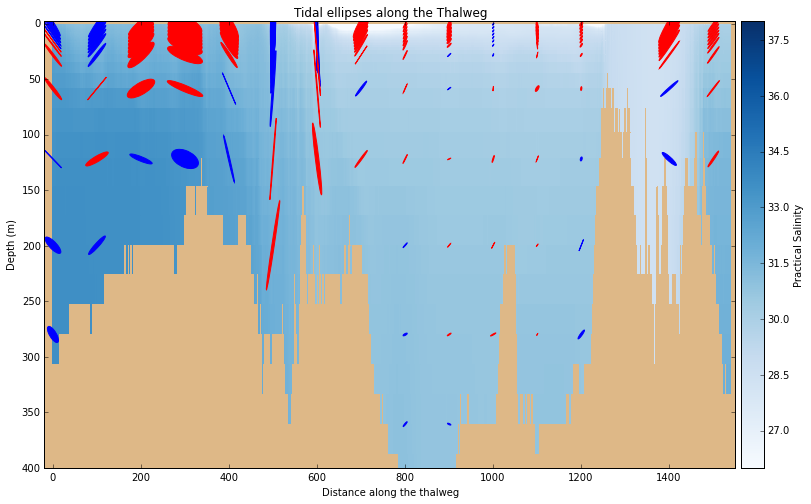

In [211]:
# Set up the figure and axes
fig, (axl, axcb) = plt.subplots(1, 2, figsize=(16, 8))
land_colour = 'burlywood'
axl.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))

smin, smax, dels = 26, 38, 0.5
cmap = plt.get_cmap('Blues')
cmap.set_bad(land_colour)
tracers = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/18sep27sep/SalishSea_1d_20030918_20030927_grid_T.nc')
sal = tracers.variables['vosaline']
npsal = sal[:]
zlevels = tracers.variables['deptht']
sal_0 = npsal[-1, :, thalweg[0], thalweg[1]]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)
mesh = axl.pcolormesh(x, z, sal_tzyx.T, cmap=cmap, vmin=smin, vmax=smax)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity')

scale = 100
count = np.arange(0,15)
k = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1400, 1500]

for loc, k in zip(count, k):
    for dep, value in zip(np.arange(0,39,3), params[0,:,0][::3]):
        if params[loc,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(xy=(k, value), width=scale*params[loc,dep,1], 
                            height=scale*params[loc,dep,2], angle=params[loc, dep,3],
                            color=thec)
        axl.add_artist(ellsc)
        ellsc.set_facecolor(thec)


axl.set_ylim(-2,400)
axl.invert_yaxis()
axl.set_xlim(-20,1550)
axl.set_title('Tidal ellipses along the Thalweg')
axl.set_ylabel('Depth (m)')
axl.set_xlabel('Distance along the thalweg')